In [1]:
# !pip install torchinfo
# !pip install torchmetrics
# !pip install torchsummary

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# from google.colab.patches import cv2_imshow as imshow

In [3]:
# !unzip "/content/gdrive/MyDrive/Dataset.zip" -d "/content/gdrive/MyDrive/SAR_Dataset"

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import os
import torchinfo

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:
class SARData(Dataset):
    def __init__(self):
        
        self.xtrain_path = '/kaggle/input/sar8bit/Dataset/img_dir'
        self.ytrain_path = '/kaggle/input/sar8bit/Dataset/ann_dir_8bit'
        self.xtrain_imgs = np.array(os.listdir(self.xtrain_path))[:3000]
        self.ytrain_imgs = np.array(os.listdir(self.ytrain_path))[:3000]
        self.num_classes = 5
        self.height, self.width = 256,256

    def process_label(self, label):
        r = []
        for i in range(self.num_classes):
            mask = label == i+1
            mask = mask.float()
            r.append(mask)
        return torch.stack(r)
    
    def __len__(self):
        return len(self.ytrain_imgs)
    
    def __getitem__(self, idx):        
        xtrain = cv.imread(f"{self.xtrain_path}/{self.xtrain_imgs[idx]}")
        xtrain = cv.cvtColor(xtrain, cv.COLOR_BGR2RGB)
        xtrain = torch.tensor(xtrain).permute(2,0,1) #HWC -> CHW
        
        ytrain = cv.imread(f"{self.ytrain_path}/{self.ytrain_imgs[idx]}", cv.IMREAD_GRAYSCALE)
        ytrain = torch.tensor(ytrain)
        processed_ytrain = self.process_label(ytrain)
        
        
        return xtrain, processed_ytrain 

In [6]:
def visualize_sample(img, label):
    fig, ax = plt.subplots(1, 6, figsize=(20,20)) 
    for i, subplot_ax in zip(range(data.num_classes + 1), ax.flatten()):
        if i == 0: 
            subplot_ax.imshow(img.permute(1,2,0))
            subplot_ax.set_title(f'Training Sample')
        else:
            subplot_ax.imshow(label[i-1], cmap='gray', vmin=0, vmax=1)
            subplot_ax.set_title(f'Label {i}')

def visualize_predictions(model, img):
    inp = (img - 127.5) / 255
    inp = torch.unsqueeze(inp, dim=0)
    pred = model(inp)
    visualize_sample(img, pred.squeeze().detach().numpy())

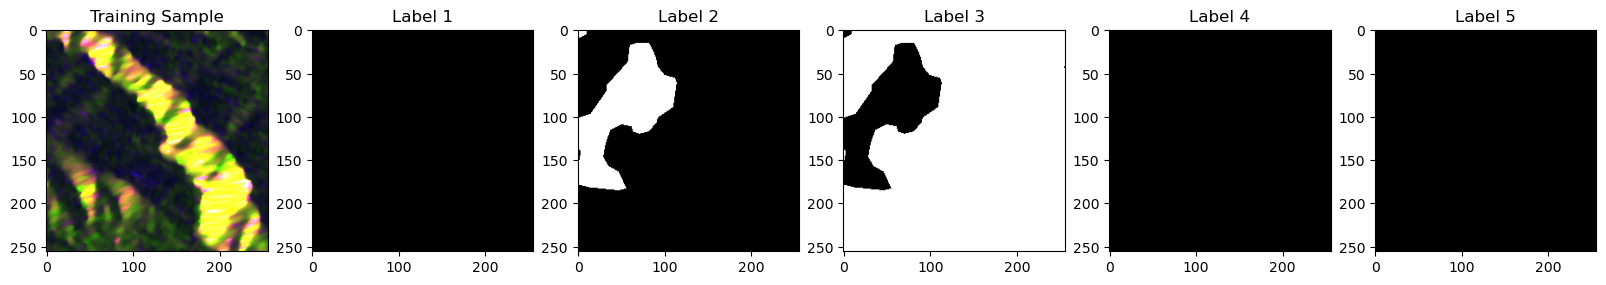

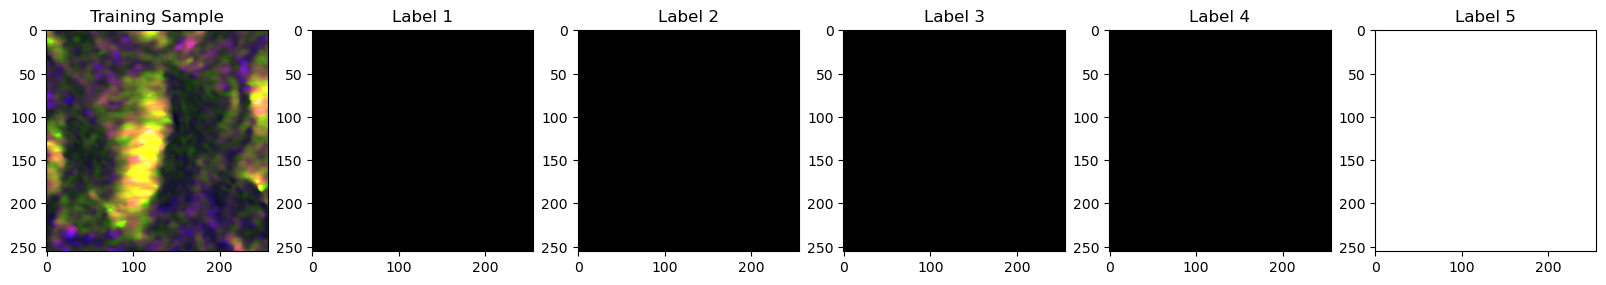

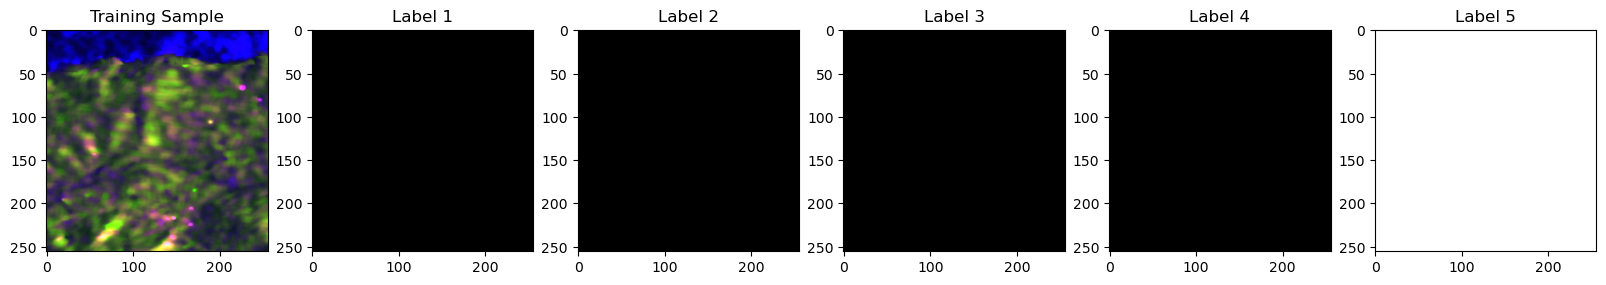

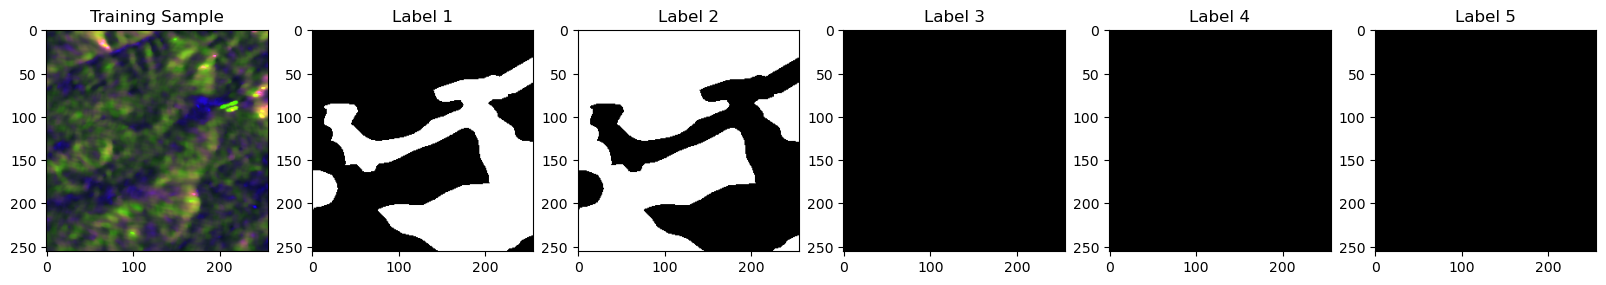

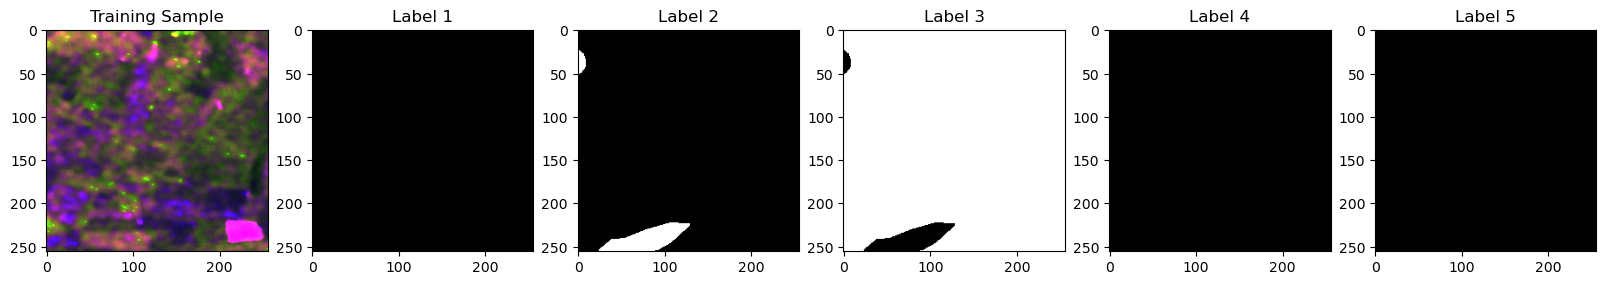

In [7]:
data = SARData()
idx = (torch.randint(0, 3000, (5,)))

for i in idx:
    img, label = data.__getitem__(i)
    visualize_sample(img, label)

In [8]:
def double_conv(in_channels, out_channels):
    conv = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1),
        nn.ReLU()
    )
    return conv

def double_Tconv(in_channels, out_channels):
    Tconv = nn.Sequential(
        nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1),
        nn.ReLU()
    )
    return Tconv

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.max_unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.conv1 = double_conv(3, 64)
        self.conv2 = double_conv(64, 128)
        self.conv3 = double_conv(128, 256)
        self.conv4 = double_conv(256, 512)
        self.conv5 = double_conv(512, 1024)
        self.Tconv5 = double_Tconv(1024, 512)
        self.Tconv4 = double_Tconv(512, 256)
        self.Tconv3 = double_Tconv(256, 128)
        self.Tconv2 = double_Tconv(128, 64)
        self.Tconv1 = double_Tconv(64, 5)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        c1 = self.conv1(x)
        c1 = self.bn1(c1)
        x1, i1 = self.max_pool(c1)

        c2 = self.conv2(x1)
        c2 - self.bn2(c2)
        x2, i2 = self.max_pool(c2)
        
        c3 = self.conv3(x2)
        c3 = self.bn3(c3)
        x3, i3 = self.max_pool(c3)

        c4 = self.conv4(x3)
        c4 = self.bn4(c4)
        x4, i4 = self.max_pool(c4)
        
        i = self.conv5(x4)
        
        t4 = self.Tconv5(i)
        
        z4 = self.max_unpool(t4, i4, output_size=c4.size())
        t3 = self.Tconv4(z4)
        
        z3 = self.max_unpool(t3, i3, output_size=c3.size())
        t2 = self.Tconv3(z3)
        
        z2 = self.max_unpool(t2, i2, output_size=c2.size())
        t1 = self.Tconv2(z2)
        
        z1 = self.max_unpool(t1, i1, output_size=c1.size())
        out = self.Tconv1(z1)
        
        return self.softmax(out)
        

In [9]:
model = Network()
# model.eval()
torchinfo.summary(model, (1,3,256,256))

Layer (type:depth-idx)                   Output Shape              Param #
Network                                  [1, 5, 256, 256]          --
├─Sequential: 1-1                        [1, 64, 252, 252]         --
│    └─Conv2d: 2-1                       [1, 64, 254, 254]         1,792
│    └─ReLU: 2-2                         [1, 64, 254, 254]         --
│    └─Conv2d: 2-3                       [1, 64, 252, 252]         36,928
│    └─ReLU: 2-4                         [1, 64, 252, 252]         --
├─BatchNorm2d: 1-2                       [1, 64, 252, 252]         128
├─MaxPool2d: 1-3                         [1, 64, 126, 126]         --
├─Sequential: 1-4                        [1, 128, 122, 122]        --
│    └─Conv2d: 2-5                       [1, 128, 124, 124]        73,856
│    └─ReLU: 2-6                         [1, 128, 124, 124]        --
│    └─Conv2d: 2-7                       [1, 128, 122, 122]        147,584
│    └─ReLU: 2-8                         [1, 128, 122, 122]        -

Pre Training: 


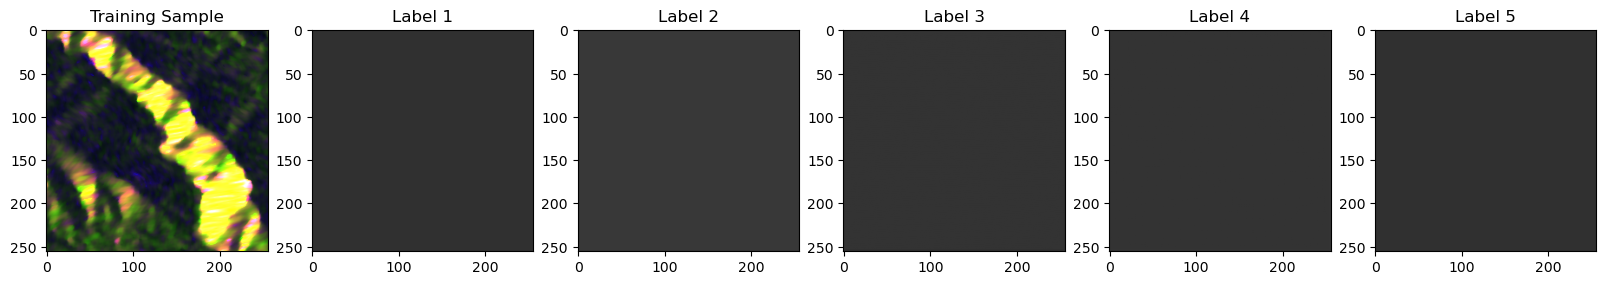

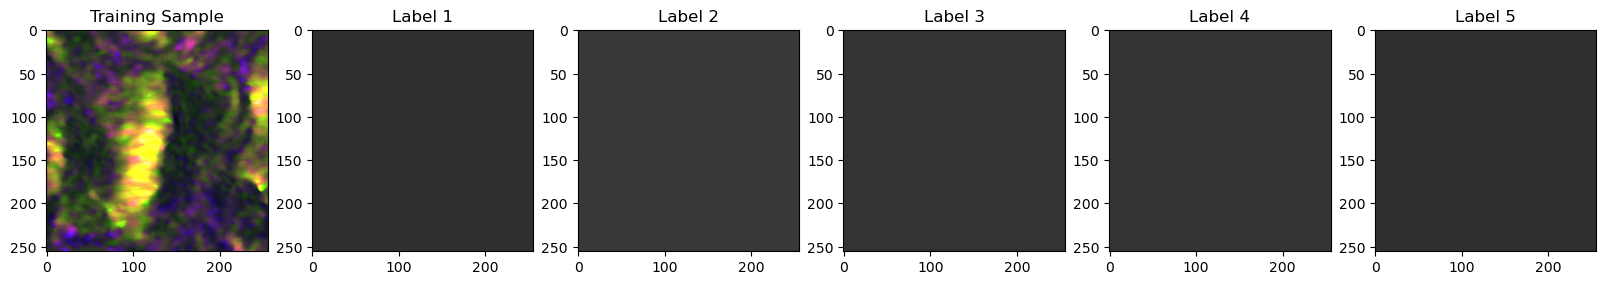

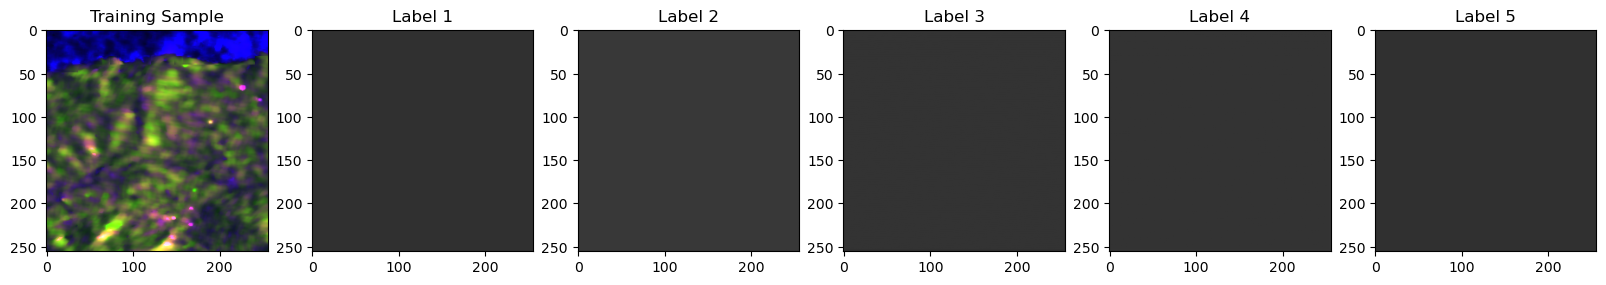

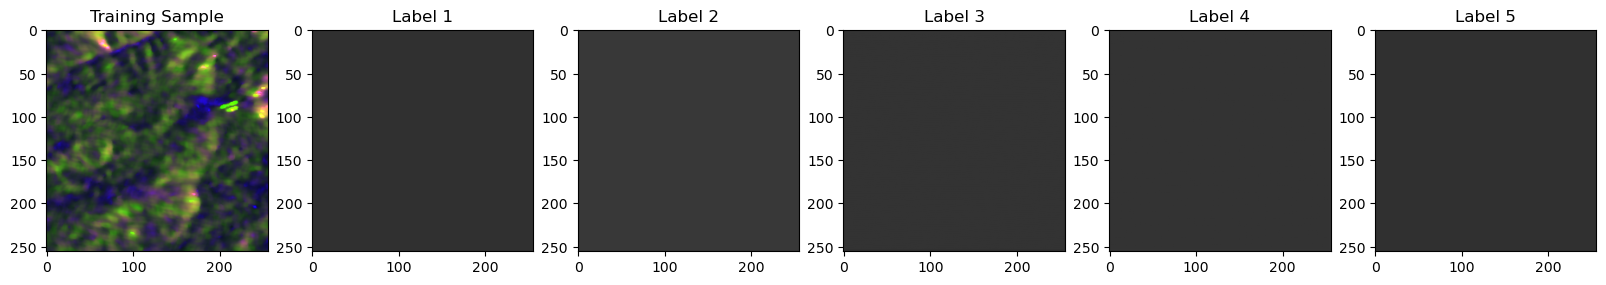

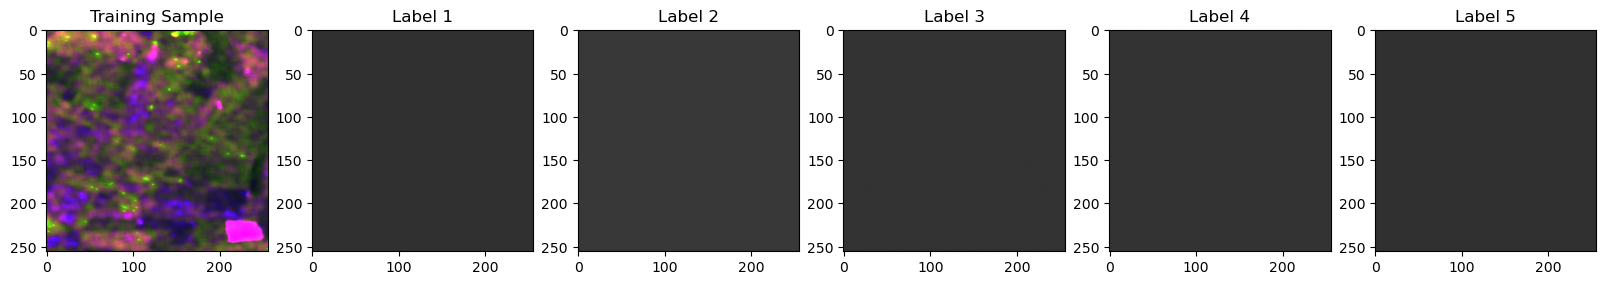

In [10]:
print('Pre Training: ')
model.eval()
model.to('cpu')
for i in idx:
    img, label = data.__getitem__(i)
    visualize_predictions(model, img)

In [11]:
epochs = 50
batch_size = 8
lr = 1e-2
loss_fn = nn.CrossEntropyLoss()

In [12]:
model.train()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_size = len(data)
trainloader = DataLoader(data, batch_size=batch_size, shuffle=True)
train_loss_hist = []

model = model.to(device)

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    
    total_train_loss=0
    val_loss=0
    
    #Training Loop
    for batch, (x,y) in enumerate(trainloader):
        x, y = x.to(device), y.to(device)
        x = (x - 127.5) / 255
        
        #Forward prop
        preds = model(x)
        loss = loss_fn(preds, y)
        total_train_loss += loss.item()
        
        #Backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    avg_train_loss = total_train_loss / train_size
    print(f"Total Training Loss: {total_train_loss:<7f}")
    print(f"Avg Training Loss  : {avg_train_loss:<7f}")
    train_loss_hist.append(total_train_loss)

Epoch 1/50
Total Training Loss 598.0053932666779
Avg Training Loss 0.19933513108889261
Epoch 2/50
Total Training Loss 589.4810810089111
Avg Training Loss 0.19649369366963704
Epoch 3/50
Total Training Loss 576.9701336622238
Avg Training Loss 0.19232337788740794
Epoch 4/50
Total Training Loss 566.7709854841232
Avg Training Loss 0.18892366182804107
Epoch 5/50
Total Training Loss 561.732635140419
Avg Training Loss 0.187244211713473
Epoch 6/50
Total Training Loss 559.4690598249435
Avg Training Loss 0.18648968660831453
Epoch 7/50
Total Training Loss 558.3243895769119
Avg Training Loss 0.18610812985897066
Epoch 8/50
Total Training Loss 557.7112476825714
Avg Training Loss 0.1859037492275238
Epoch 9/50
Total Training Loss 557.341296672821
Avg Training Loss 0.18578043222427368
Epoch 10/50
Total Training Loss 557.1694231033325
Avg Training Loss 0.18572314103444418
Epoch 11/50
Total Training Loss 556.9410549402237
Avg Training Loss 0.1856470183134079
Epoch 12/50
Total Training Loss 556.83784258365

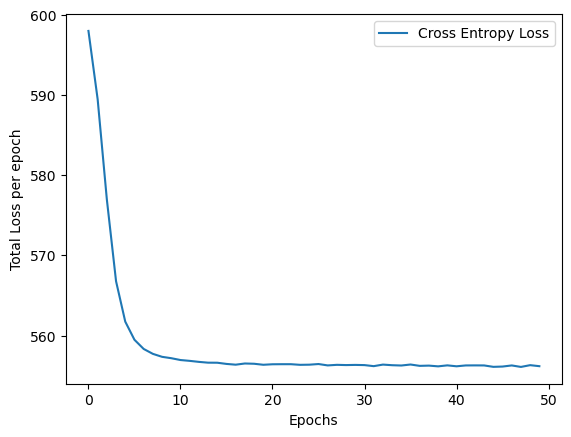

In [13]:
plt.ylabel('Total Loss per epoch')
plt.xlabel('Epochs')
plt.plot(train_loss_hist, label='Cross Entropy Loss')
plt.legend()
plt.show()

Post Training: 


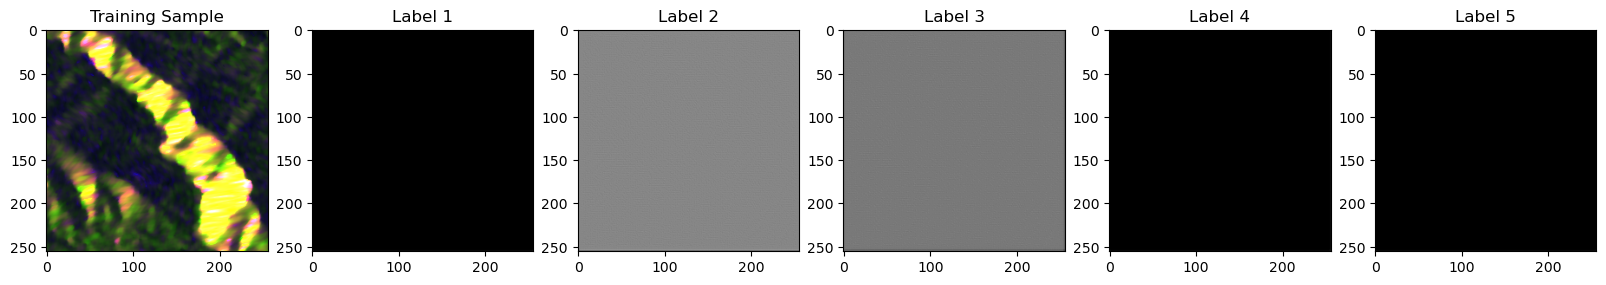

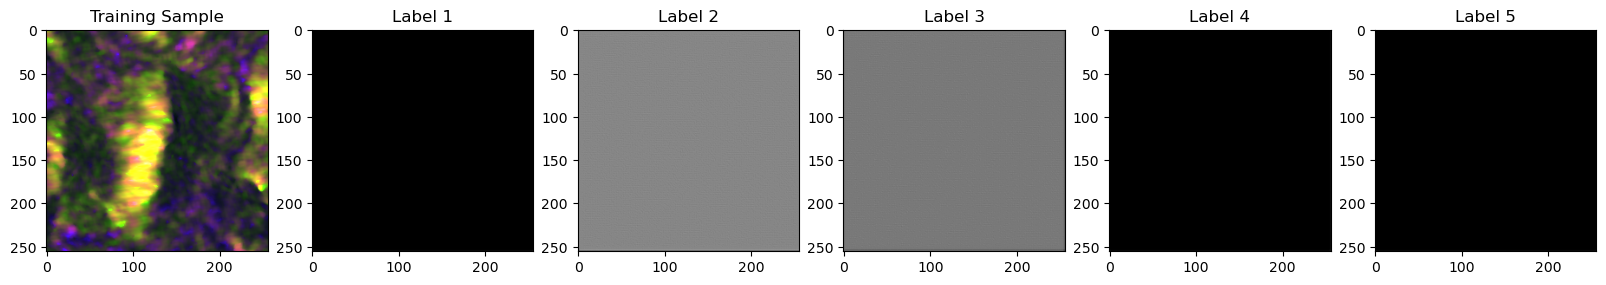

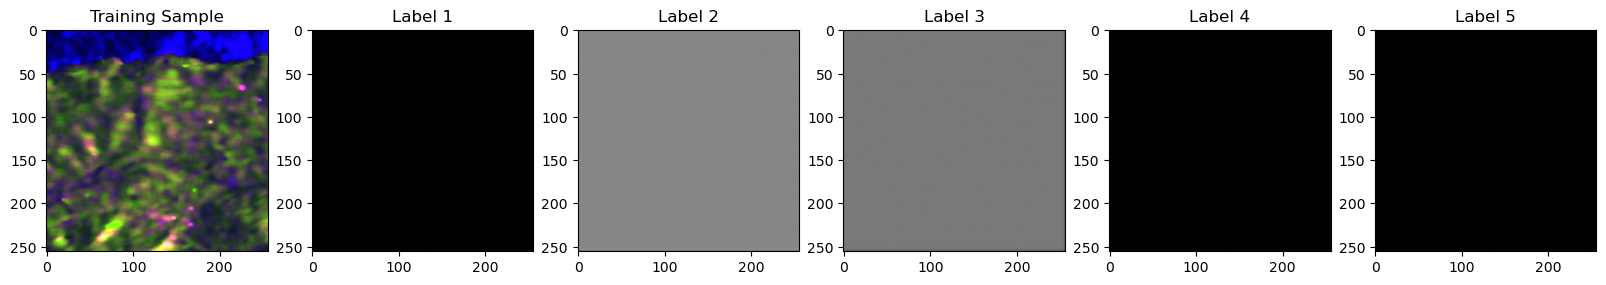

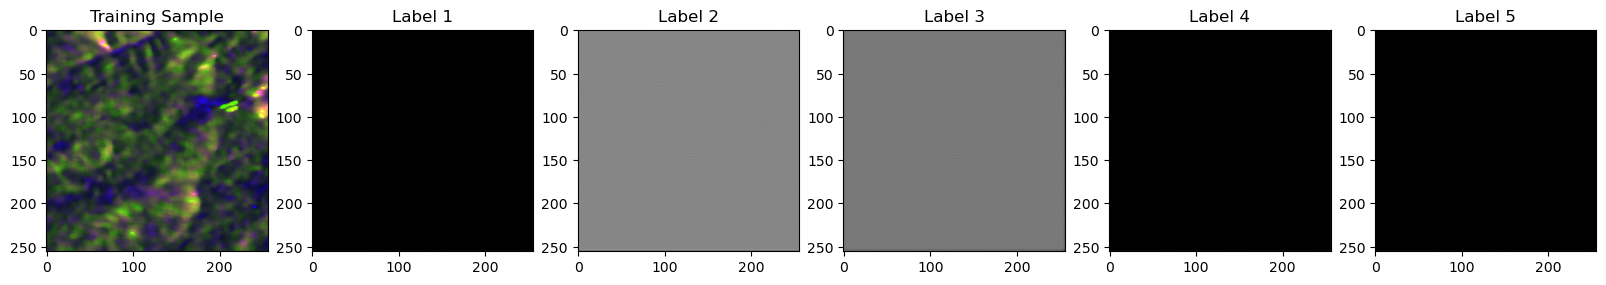

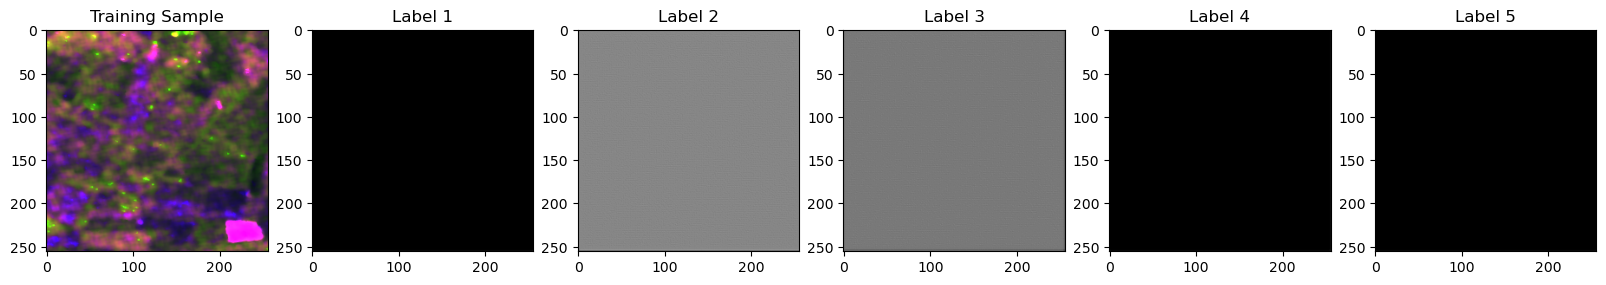

In [14]:
print('Post Training: ')
model.to('cpu')
model.eval()
for i in (idx):
    img, label = data.__getitem__(i)
    visualize_predictions(model, img)